In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
import string

In [31]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

In [4]:
os.chdir('/Users/ethancz/Downloads/data/dota/archive-3')
corpus = pd.read_csv('chat.csv')

In [5]:
corpus.drop(columns=['match_id', 'unit'], inplace=True)

In [6]:
corpus['key'] = corpus['key'].apply(str)
corpus['tokens'] = corpus['key'].str.split(' ')

In [7]:
corpus['length'] = corpus['tokens'].apply(len)
corpus['charlength'] = corpus['key'].apply(len)

In [8]:
words = []
for i in range(corpus.shape[0]):
    message_length = len(corpus['tokens'].iloc[i])
    for j in range(message_length):
        words.append(corpus['tokens'].iloc[i][j])
        
cleanwords = []
for word in words:
    word = word.lower()
    word = word.translate(str.maketrans('', '', string.punctuation))
    if word != '':
        cleanwords.append(word)

In [9]:
#Saving the words to a text file
with open('words.txt', 'w') as f:
    for word in cleanwords:
        f.write(word)
        f.write('\n')
f.close()

In [10]:
#Examining the most frequently appearing words
word_df = pd.DataFrame(cleanwords, columns=['token'])
counts = word_df.value_counts().rename_axis('token').reset_index(name='counts')

In [12]:
counts.head(10)

,token,counts
0,gg,123480
1,ez,48977
2,lol,48168
3,i,45502
4,you,38095
5,u,37732
6,wp,33546
7,report,30274
8,is,27131
9,a,27126


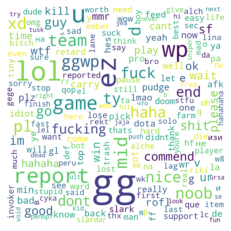

In [15]:
#Generating a word cloud
wc = wordcloud.WordCloud(width=1000, height=1000, random_state=24, 
              max_font_size=175, background_color='white',
                        collocations=False).generate(' '.join(cleanwords))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off');
#wc.to_file('dota word cloud.png');

In [16]:
#Dropping everything from the corpus that isn't written in the Latin alphabet
indices = []
for i in range(corpus.shape[0]):
    for char in corpus['key'].iloc[i].lower():
        if char not in "qwertyuiopasdfghjklzxcvbnm1234567890,=^@#$&_<>[]{}()!?.\/:;'+-*":
            indices.append(i)
            break
        break
        
corpus_latin = corpus.copy()
corpus_latin.drop(axis=0, index=indices, inplace=True)

In [17]:
#Exclusively using VADER and not textblob for polarity analysis
#VADER is specifically attuned to online contexts
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [18]:
corpus_latin['scores'] = corpus_latin['key'].apply(analyzer.polarity_scores)

In [19]:
def vader_analysis(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [20]:
compounds = []
for i in range(corpus_latin.shape[0]):
    compounds.append(corpus_latin['scores'].iloc[i]['compound'])    
corpus_latin['compounds'] = compounds

corpus_latin['analysis'] = corpus_latin['compounds'].apply(vader_analysis)
corpus_latin.drop(columns=['compounds'], inplace=True)

In [22]:
#Positive, negative, neutral messages
pos = corpus_latin[corpus_latin['analysis'] == 'positive']
neg = corpus_latin[corpus_latin['analysis'] == 'negative']
neutral = corpus_latin[corpus_latin['analysis'] == 'neutral']

In [23]:
#Percentages for each category
posp = round((pos.shape[0]/corpus_latin.shape[0])*100, 1)
negp = round((neg.shape[0]/corpus_latin.shape[0])*100, 1)
neutralp = round((neutral.shape[0]/corpus_latin.shape[0])*100, 1)
print('Positive: {}%, negative: {}%, neutral: {}%'.format(posp, negp, neutralp))

Positive: 35.9%, negative: 14.0%, neutral: 50.1%


In [24]:
#Positive, negative, neutral words

poswords = []
for i in range(pos.shape[0]):
    message_length = len(pos['key'].iloc[i].split())
    for j in range(message_length):
        poswords.append(pos['key'].iloc[i].split()[j].lower())
        
negwords = []
for i in range(neg.shape[0]):
    message_length = len(neg['key'].iloc[i].split())
    for j in range(message_length):
        negwords.append(neg['key'].iloc[i].split()[j].lower())
        
neutralwords = []
for i in range(neutral.shape[0]):
    message_length = len(neutral['key'].iloc[i].split())
    for j in range(message_length):
        neutralwords.append(neutral['key'].iloc[i].split()[j].lower())

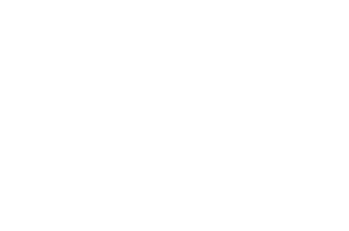

In [27]:
#Word clouds for each sentiment judgment

wc = wordcloud.WordCloud(width=1000, height=1000, random_state=24, 
              max_font_size=250, background_color='white',
                        collocations=False).generate(' '.join(poswords))
#plt.imshow(wc, interpolation='bilinear')
plt.axis('off');
#wc.to_file('positive cloud.png');

wc2 = wordcloud.WordCloud(width=1000, height=1000, random_state=24, 
              max_font_size=225, background_color='white',
                        collocations=False).generate(' '.join(negwords))
#plt.imshow(wc, interpolation='bilinear')
plt.axis('off');
#wc2.to_file('negative cloud.png');

wc3 = wordcloud.WordCloud(width=1000, height=1000, random_state=24, 
              max_font_size=200, background_color='white',
                        collocations=False).generate(' '.join(neutralwords))
#plt.imshow(wc, interpolation='bilinear')
plt.axis('off');
#wc3.to_file('neutral cloud.png');

In [28]:
#Plotting some plots

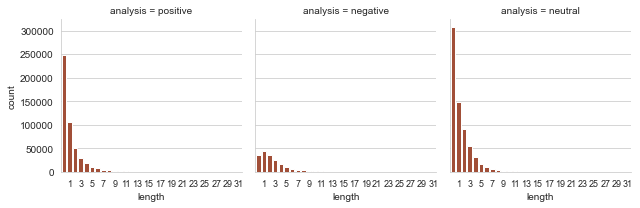

In [32]:
g = sns.FacetGrid(corpus_latin, col='analysis', col_order=['positive', 'negative', 'neutral'])
g.map(sns.countplot, 'length', color='#B24526')
g.set(xticks=np.arange(1,32,2))
g.set_xticklabels(np.arange(1,32,2), size=9);
#plt.savefig('facetgrid length', bbox_inches='tight', format='eps')

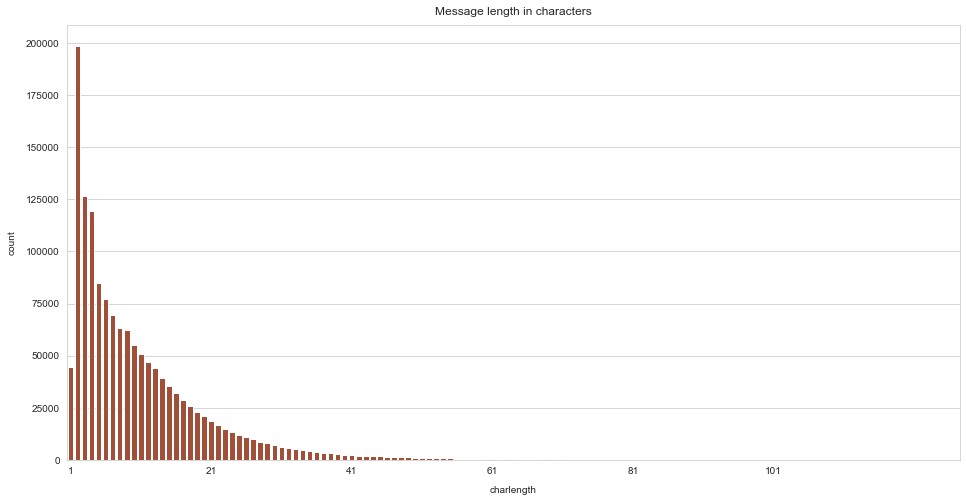

In [33]:
plt.figure(figsize=(16,8))
sns.countplot(data=corpus, x='charlength', color='#B24526')
plt.xticks(np.arange(0,101,20))
plt.xlabel('charlength', labelpad=10)
plt.ylabel('count', labelpad=10)
plt.title('Message length in characters', pad=10);
#plt.savefig('message length char', bbox_inches='tight', format='eps')